## [NLP GD-2] 프로젝트: SentencePiece 사용하기

> * 네이버 영화리뷰 감정분석 코퍼스에 sentencepiece를 적용시킨 모델 학습하기
> * 학습된 모델로 **sp_tokenize() 메소드 구현**하기
> * 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정분석 모델을 **재학습**하기
> * KoNLPy 형태소 분석기를 사용한 모델과 **성능 비교**하기
> * (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인한다.
>  Word Vector는 활용할 필요가 없다. 활용이 가능하지도 않을 것이다. 머지않아 SentencePiece와 BERT 등의 pretrained 모델을 함께 활용하는 태스크를 다루게 될 것이다.

## 1. 데이터 다운로드 및 전처리

데이터: 네이버 영화리뷰 감정분석 태스크
https://github.com/e9t/nsmc/

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np

In [2]:
import os
from os.path import join

path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/naver_movies'

train_data = join(path_to_file, 'ratings_train.txt')
test_data = join(path_to_file, 'ratings_test.txt')

train_data = pd.read_table(train_data)    # txt. 데이터는 pd.read_table
test_data = pd.read_table(test_data)   

### 1-1. 학습 데이터

In [7]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 148848


In [8]:
train_data[:5] # 학습 데이터 상위 5개 출력

,9050711,코난이 보여준 최악의 정수,0
0,10269943,꼭 봐야하는 영화라고 생각합니다. 왜냐면 실제로 일어나고 있는 우리나라 현실이니까요.,1
1,8204981,김지수 코트 이뿌다. 한혜진 대사 톤 이상해 연극 속 독백같아. 혼자 붕 뜬다. 좀...,0
2,5795537,슬펏지만 보는동안 행복했어요ㅎ 아침에일어나면 엄마꼭안아줘야될것같아요ㅎㅎ,1
3,8717408,관리들 풍자ㅋㅋㅋ웃김,1
4,9469958,명작중명작이죠 진짜잘만듬,1


In [9]:
train_data.tail()   # 학습 데이터 하위 5개 출력

,9050711,코난이 보여준 최악의 정수,0
148843,10214450,별생각없이 봤다가 울고있움 ㅠㅠㅠㅠ,1
148844,5002968,"전형적인 액션영화,,,별다른게없다 ~~~~~~~",0
148845,10268889,재밌습니다 툭히유아인 연기대박,1
148846,2937575,명대사 : 잘했어선동렬,0
148847,3826662,헐 난 하나도안지루하던데-_- 캐명작 ㄷㄷㄷ 재미없을지알고 미루다가 이제서야봤네,1


In [10]:
# 불필요한 행 삭제하기

train_data = train_data.drop(columns=['9050711'])

In [11]:
train_data.head()

,코난이 보여준 최악의 정수,0
0,꼭 봐야하는 영화라고 생각합니다. 왜냐면 실제로 일어나고 있는 우리나라 현실이니까요.,1
1,김지수 코트 이뿌다. 한혜진 대사 톤 이상해 연극 속 독백같아. 혼자 붕 뜬다. 좀...,0
2,슬펏지만 보는동안 행복했어요ㅎ 아침에일어나면 엄마꼭안아줘야될것같아요ㅎㅎ,1
3,관리들 풍자ㅋㅋㅋ웃김,1
4,명작중명작이죠 진짜잘만듬,1


In [12]:
train_data.describe()

,코난이 보여준 최악의 정수,0
count,148843,148848
unique,145032,3
top,굿,0
freq,181,74483


In [13]:
train_data['0'].value_counts(normalize=True)   # 칼럼 값 빈도수 확인

0        0.500396
1        0.499597
label    0.000007
Name: 0, dtype: float64

In [14]:
col = train_data['0'] == 'label'
train_data[col]

,코난이 보여준 최악의 정수,0
84410,document,label


In [15]:
train_data = train_data.rename(columns = train_data.iloc[84410])

In [16]:
train_data

,document,label
0,꼭 봐야하는 영화라고 생각합니다. 왜냐면 실제로 일어나고 있는 우리나라 현실이니까요.,1
1,김지수 코트 이뿌다. 한혜진 대사 톤 이상해 연극 속 독백같아. 혼자 붕 뜬다. 좀...,0
2,슬펏지만 보는동안 행복했어요ㅎ 아침에일어나면 엄마꼭안아줘야될것같아요ㅎㅎ,1
3,관리들 풍자ㅋㅋㅋ웃김,1
4,명작중명작이죠 진짜잘만듬,1
...,...,...
148843,별생각없이 봤다가 울고있움 ㅠㅠㅠㅠ,1
148844,"전형적인 액션영화,,,별다른게없다 ~~~~~~~",0
148845,재밌습니다 툭히유아인 연기대박,1
148846,명대사 : 잘했어선동렬,0


In [17]:
train = train_data[train_data['label'] == 'label']. index
train = train_data.drop(train)                # 행 삭제

In [18]:
 # document 열에서 중복인 내용이 있다면 중복 제거
train.drop_duplicates(subset=['document'], inplace=True)

In [19]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 148848


<AxesSubplot:>

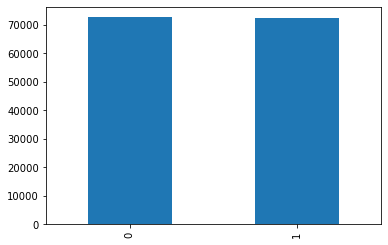

In [20]:
# label 값 분포 확인
train['label'].value_counts().plot(kind = 'bar')

In [21]:
# label 값 빈도 확인
print(train.groupby('label').size().reset_index(name = 'count'))

  label  count
0     0  72666
1     1  72366


In [22]:
# 결측값 확인: True면 결측값 존재
print(train.isnull().values.any())

True


In [23]:
# 컬럼별 결측값 카운트
print(train.isnull().sum())

document    1
label       0
dtype: int64


In [24]:
# 결측값이 있는 위치 확인
train.loc[train.document.isnull()]

,document,label
24942,NaN,0


In [25]:
train = train.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [26]:
# 정규표현식 사용: 한글과 공백을 제외하고 모두 제거
train['document'] = train['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train[:5]

/home/aiffel-dj23/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,document,label
0,꼭 봐야하는 영화라고 생각합니다 왜냐면 실제로 일어나고 있는 우리나라 현실이니까요,1
1,김지수 코트 이뿌다 한혜진 대사 톤 이상해 연극 속 독백같아 혼자 붕 뜬다 좀 자연...,0
2,슬펏지만 보는동안 행복했어요ㅎ 아침에일어나면 엄마꼭안아줘야될것같아요ㅎㅎ,1
3,관리들 풍자ㅋㅋㅋ웃김,1
4,명작중명작이죠 진짜잘만듬,1


[참고] 정규표현식
* https://www.unicode.org/charts/PDF/U3130.pdf
* https://www.unicode.org/charts/PDF/UAC00.pdf

In [27]:
# 한글이 없는 리뷰는 빈값이 되었으므로 확인

train['document'] = train['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train['document'].replace('', np.nan, inplace=True)
print(train.isnull().sum())

document    787
label         0
dtype: int64


/home/aiffel-dj23/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
# 빈 값을 가지고 있는 행 확인 

train.loc[train.document.isnull()][:5]

,document,label
125,NaN,1
214,NaN,1
574,NaN,0
820,NaN,1
913,NaN,0


In [29]:
# 빈 값을 가지고 있는 행 삭제

train = train.dropna(how = 'any')
print(len(train))

144244


### 1-2. 테스트 데이터

In [30]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [31]:
test_data.head() # 상위 5개 출력

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [32]:
 # document 열에서 중복인 내용이 있다면 중복 제거

test_data.drop_duplicates(subset = ['document'], inplace=True)

In [33]:
# 정규 표현식 수행

test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

/home/aiffel-dj23/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
 # 공백은 empty 값으로 변경

test_data['document'] = test_data['document'].str.replace('^ +', "")

/home/aiffel-dj23/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
# 공백은 Null 값으로 변경

test_data['document'].replace('', np.nan, inplace=True) 

In [36]:
# Null 값 제거

test_data = test_data.dropna(how='any') 

In [37]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


### 1-3. 토큰화

> * 불용어(stopwords): 토큰화 과정에서 불용어를 제거한다. 불용어는 정의하기 나름이며, 현업에서는 일반적으로 아래의 불용어 보다 더 많은 불용어를 사용한다.
> * 토큰화를 위한 형태소 분석기는 KoNLPy의 Okt를 사용한다. Okt는 영어처럼 띄어쓰기를 기준으로 토큰화를 하는 것이 아니라, 형태소 분석기를 사용한다. 

In [34]:
# 학습 데이터 토큰화

from konlpy.tag import Okt

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

# 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장
X_train = []
for sentence in train['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [35]:
# 상위 3개 샘플 출력 확인
print(X_train[:3])

[['꼭', '보다', '야하다', '영화', '라고', '생각', '왜냐면', '실제', '로', '일어나고', '있다', '우리나라', '현실', '이니까', '요'], ['김지수', '코트', '이뿌다', '한혜진', '대사', '톤', '이상하다', '연극', '속', '독백', '같다', '혼자', '붕', '뜨다', '자연', '스럽게', '해주다', '현', '학적', '인', '추상', '적', '인', '대사', '공허하다'], ['슬펏', '지만', '보다', '동안', '행복하다', 'ㅎ', '아침', '일어나다', '엄마', '꼭', '안다', '되다', '같다', 'ㅎㅎ']]


In [36]:
# 테스트 데이터 토큰화

X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

### 1-4. 정수 인코딩

In [37]:
# 기계가 텍스트를 숫자로 처리할 수 있도록 학습 데이터와 테스트 데이터에 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 단어 집합 생성 및 각 단어에 고유한 정수 부여 확인
# print(tokenizer.word_index)

* 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미한다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 한다. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인한다.

In [38]:
threshold = 3
total_cnt = len(tokenizer.word_index)     # 단어의 수
rare_cnt = 0                              # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                            # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                             # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 42949
등장 빈도가 2번 이하인 희귀 단어의 수: 23938
단어 집합에서 희귀 단어의 비율: 55.73587277934294
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8973708625368382


* 등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지한다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.87%밖에 되지 않는다. 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 하다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시킨다. 

In [39]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19012


*  단어 집합의 크기는 19,012개이다. 이를 케라스 토크나이저의 인자로 넘겨주면, 케라스 토크나이저는 텍스트 시퀀스를 숫자 시퀀스로 변환한다. 

In [40]:
# 숫자 시퀀스 변환

tokenizer = Tokenizer(vocab_size)    
tokenizer.fit_on_texts(X_train)  
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [41]:
# 정수 인코딩 진행되었는지 확인

print(X_train[:3])

[[147, 2, 227, 1, 134, 35, 9555, 716, 17, 7923, 6, 392, 181, 2298, 55], [6348, 9556, 4469, 8946, 330, 3120, 343, 2176, 185, 4574, 16, 646, 5205, 683, 1148, 1253, 148, 889, 6113, 32, 6579, 13, 32, 330, 3465], [13922, 228, 2, 630, 513, 296, 1158, 1243, 459, 147, 1125, 12, 16, 154]]


In [42]:
# train_data에서 y_train과 y_test를 별도로 저장

y_train = np.array(train['label'])
y_test = np.array(test_data['label'])

### 1-5. 빈 샘플 제거

In [43]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [44]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

144011
144011


/home/aiffel-dj23/anaconda3/envs/aiffel/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


### 1-6. 패딩

* 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행한다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아본다. 

리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.565942879363382


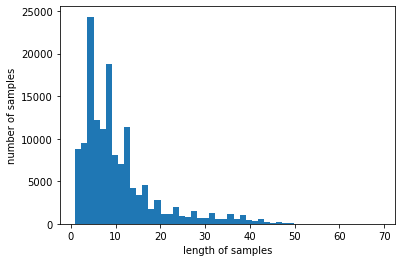

In [45]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있다. 특정 길이 변수를 max_len으로 정한다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 찾아야 한다. 이를 위해 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만든다.

In [46]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

* 위에 분포 그래프를 보면 max_len = 30이 적당할 것으로 보인다. 전체 훈련 데이터 중 30 이하의 길이를 가지는 것의 비율을 확인한다.

In [47]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.06009957572685


In [48]:
# 길이 맞춰주기

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 2.네이버 영화 리뷰 감성 분류하기

In [49]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

* 임베딩 벡터의 차원은 100으로 정했고, 리뷰 분류를 위해서 LSTM을 사용합니다. 

In [50]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

* 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후이므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)한다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장한다.

In [51]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

* 에포크는 총 12번을 수행, 학습 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인힌다.

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=12, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/12


*  훈련이 다 되었다면 이제 테스트 데이터에 대해서 정확도를 측정한다. 훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'best_model.h5'를 로드한다.

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

## 3. 리뷰 예측해 보기

* 기본적으로 현재 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용한다. 그리고 model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 한다.

In [ ]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 모델을 불러와 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

In [ ]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

## 4. SentencePiece 사용하기

### 4-1. 형태소 기반 토큰화: KoNLPy

In [38]:
from konlpy.tag import Mecab
mecab = Mecab()

In [39]:
# MeCab 단어 사전 만들기

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in train:       # 전처리한 학습 데이터
    mecab_corpus.append(mecab_split(kor))

In [41]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [42]:
# 단어 사전 길이 확인하기

mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 2


### 4-2. Sentencepiece

In [ ]:
$ pip install sentencepiece

In [52]:
# Sentencepiece 모델을 학습

import sentencepiece as spm
import os
temp_file =  os.getenv('HOME')+'/aiffel/sp_tokenizer/data/naver_movies/ratings_test.txt'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in mecab_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm01*

# 모델 학습이 완료된 후 koreanspm.model 파일과 koreanspm.vocab vocabulary 파일이 생성

RuntimeError: Internal: /sentencepiece/python/bundled/sentencepiece/src/trainer_interface.cc(579) [(trainer_spec_.vocab_size()) == (model_proto->pieces_size())] Vocabulary size too high (8000). Please set it to a value <= 20.

In [ ]:
# 모델 활용 체크

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

In [ ]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [ ]:
#sp_tokenize(s, corpus) 사용예제

tensor, word_index, index_word = sp_tokenize(s, raw)
print(tensor)

## 총평

> 데이터의 전처리 과정, 토큰화+불용어 제거, 정수 인코딩, 패딩을 통해 모델 학습을 위한 전반적인 과정을 살펴보았다. 실제적인 학습이 2시간이 지나도 진행되지 않아, 현재까지 진행된 내용을 제출한다. SentencePiece 적용에 대한 이해가 부족해서,추가 자료와 예제를 통해 보완할 예정이다.
>
> [참고] 딥러닝을 이용한 자연어 처리 입문: SentencePiece, https://wikidocs.net/86657